# Generate Dataset

In [1]:
from complex_cell_model import ComplexCellModel, gabor_fn
from Model import LeNet

import numpy as np
import matplotlib.pyplot as plt
import torch


## Import the imagenet dataset

In [2]:
images = np.load('./data/imagenet_5000.npy', allow_pickle=True)
images = (np.stack(images) / 255)[:,None,:,:]
images = torch.tensor(images, dtype=torch.float)

## Calculate the complex cell responses to the images

In [3]:
sigma = 4
Lambda = 10
complexcell = ComplexCellModel(sigma=sigma, Lambda=Lambda, theta=0.5*np.pi)

In [4]:
response = complexcell(torch.tensor(images))[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


## Visualize the example stimuli and the receptive field of the complex cell on top

In [5]:
filter1 = complexcell.filter1.cpu().numpy().squeeze()

In [7]:
x = filter1.shape[0]
image_overlap = images[4].numpy().squeeze().copy()
image_overlap[144//2-x//2:144//2+x//2+1, 256//2-x//2:256//2+x//2+1] = filter1 + 0.5

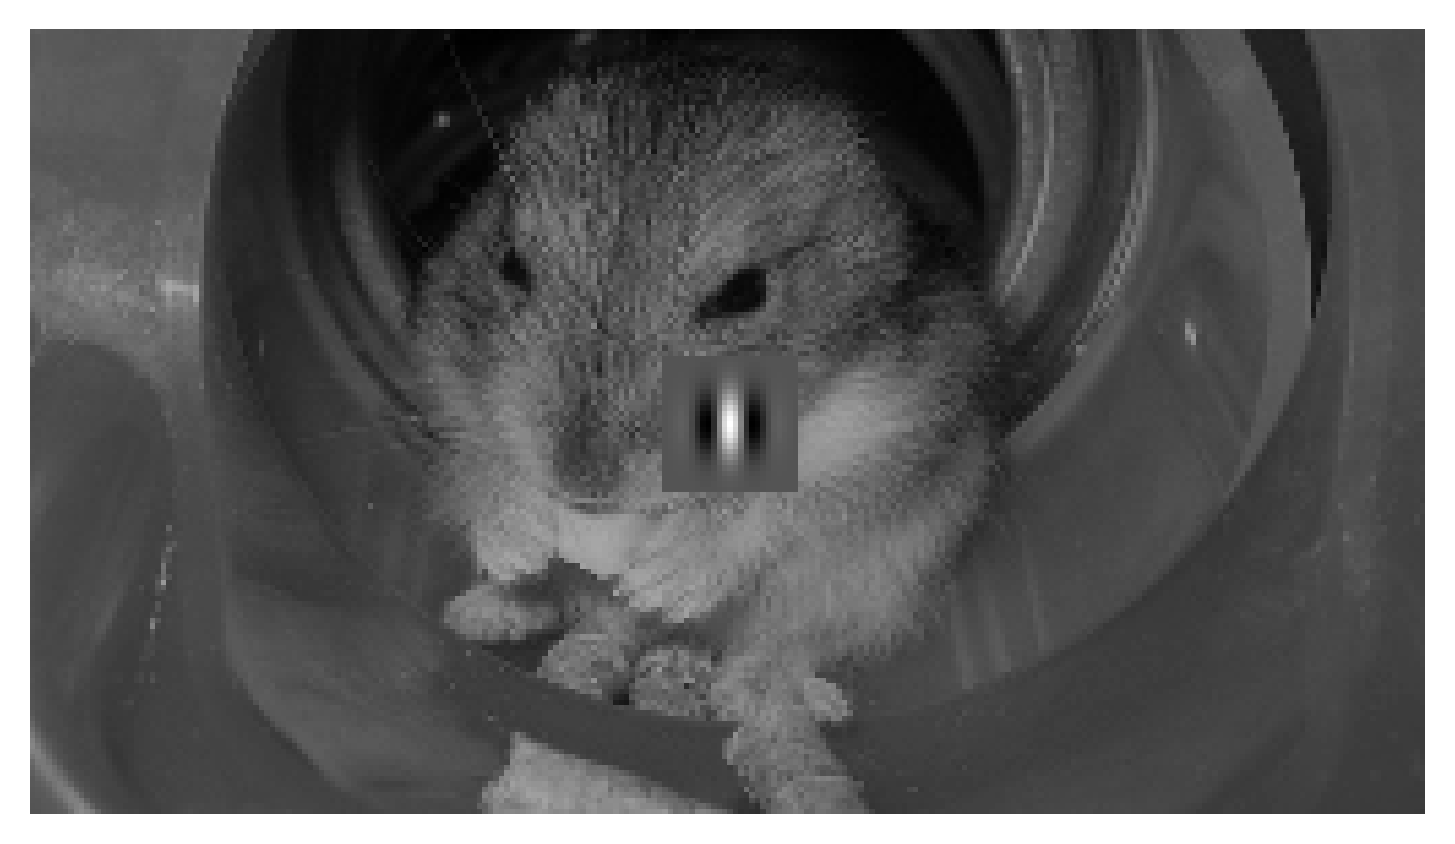

In [8]:
plt.figure(dpi=300)
plt.imshow(image_overlap, cmap='gray')
plt.axis('off')
plt.savefig('results/example_complexcell_RF')

## Plot the complex cell responses to example images

In [9]:
response = response.detach().cpu().squeeze().numpy()[:,144//2-x//2,256//2-x//2].squeeze()
images = images.detach().cpu().numpy()

Text(0.5, 0, 'Image id')

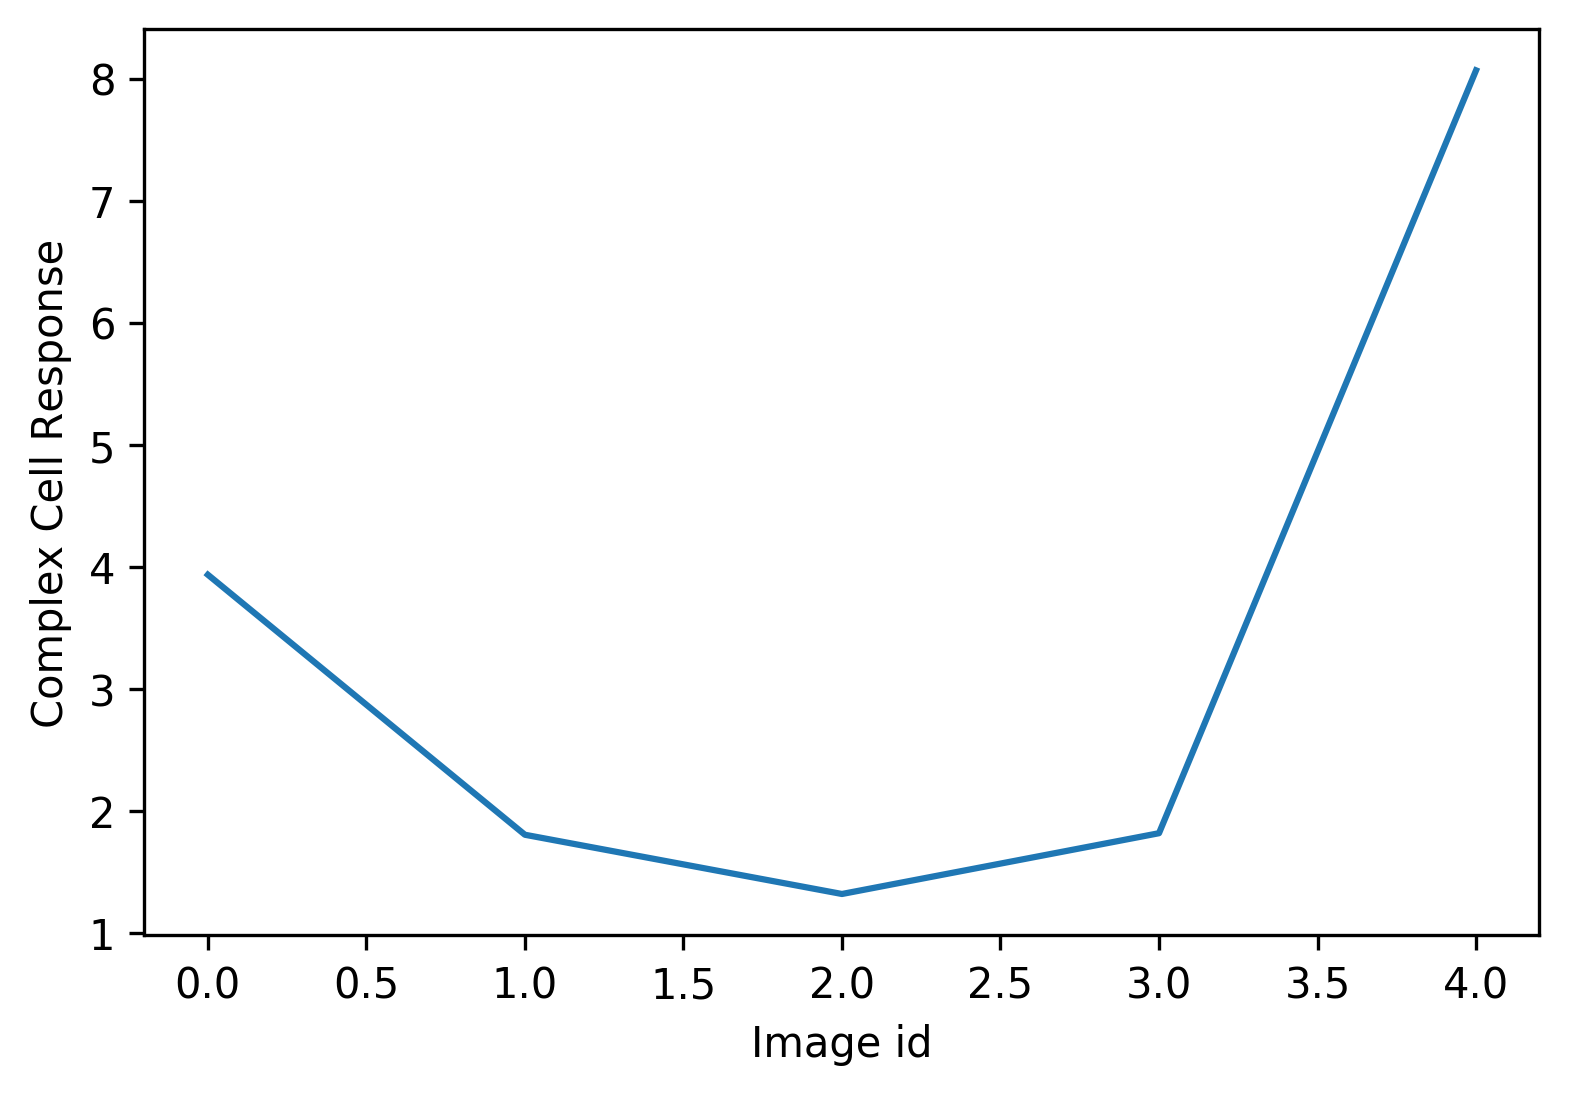

In [10]:
plt.figure(dpi=300)
plt.plot(response[:5])
plt.ylabel('Complex Cell Response')
plt.xlabel('Image id')

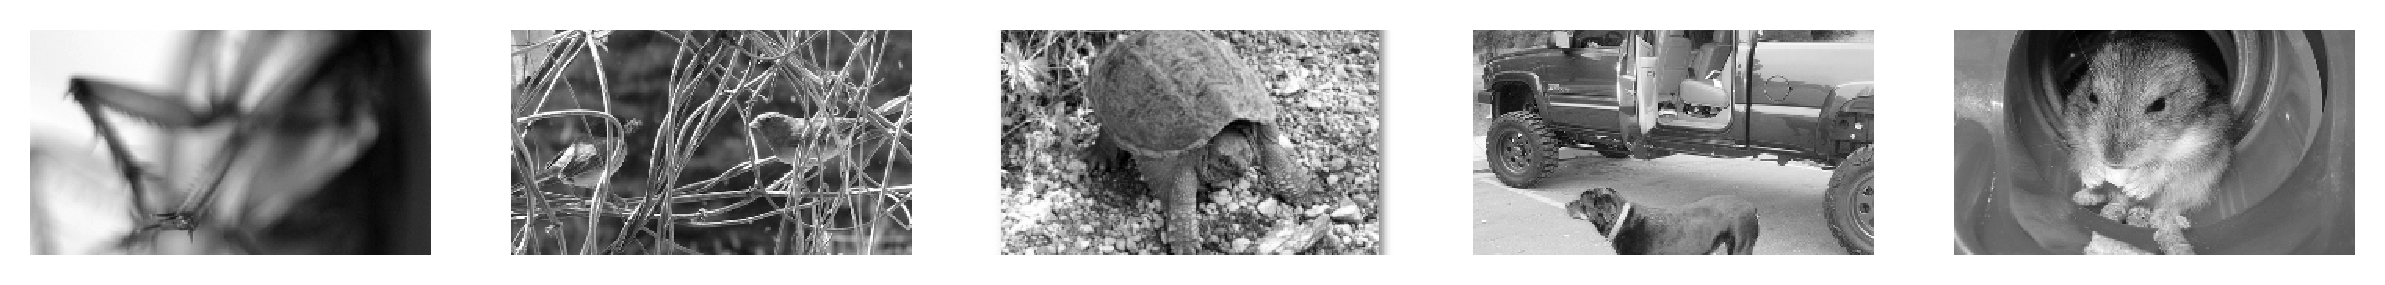

In [11]:
fig, axes = plt.subplots(1,5,figsize=(10,1),dpi=300)
for ax, im in zip(axes, images[:10]):
    ax.imshow(im.squeeze().copy(), cmap='gray')
    ax.axis('off')

## Normalize the responses and store the dataset

In [12]:
r_max = response.max(axis=0)
r_min = response.min(axis=0)
response = (response-r_min)/(r_max-r_min)

In [13]:
dataset = {}
dataset['responses'] = response
dataset['images'] = images

In [14]:
np.save('data/dataset',dataset)
del images
del response
torch.cuda.empty_cache()

# Test set

## Orientation Tuning

In [41]:
background = np.zeros((144,256))

In [42]:
test_rotation = []
gabor_rotation = []
for i in np.linspace(0,np.pi,180):
    gabor = gabor_fn(sigma=sigma, theta=i, Lambda=Lambda, psi=0, gamma=1)
    x = gabor.shape[0]
    test_image = background.copy()
    test_image[144//2-x//2:144//2+x//2+1, 256//2-x//2:256//2+x//2+1] = gabor
    test_image = (test_image - test_image.min())/(test_image.max() - test_image.min())
    test_rotation += [test_image]
    gabor_rotation += [gabor]

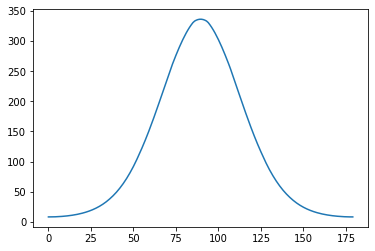

In [43]:
responses_rotation = []

for i in test_rotation:
    response = complexcell(torch.tensor(i,dtype=torch.float)[None,None,:,:])[0][:,:,144//2-x//2,256//2-x//2].cpu().detach().numpy().squeeze()
    responses_rotation.append(response)

plt.plot(responses_rotation)

In [44]:
scale = max(responses_rotation)

## Phase Tuning

In [45]:
background = np.zeros((144,256))

test_phase = []
gabor_phase = []
for i in np.linspace(0,np.pi * 2,360):
    gabor = gabor_fn(sigma=sigma, theta=np.pi/2, Lambda=Lambda, psi=i, gamma=1)
    gabor = (gabor+1)/2
    x = gabor.shape[0]
    test_image = background.copy()
    test_image[144//2-x//2:144//2+x//2+1, 256//2-x//2:256//2+x//2+1] = gabor
    test_image = (test_image - test_image.min())/(test_image.max() - test_image.min())
    test_phase += [test_image]
    gabor_phase += [gabor]

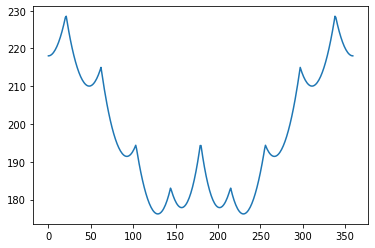

In [46]:
responses_phase = []

for i in test_phase:
    response = complexcell(torch.tensor(i,dtype=torch.float)[None,None,:,:])[0][:,:,144//2-x//2,256//2-x//2].cpu().detach().numpy().squeeze()
    responses_phase.append(response)

plt.plot(responses_phase)

Text(0.5, 0, 'Orientation')

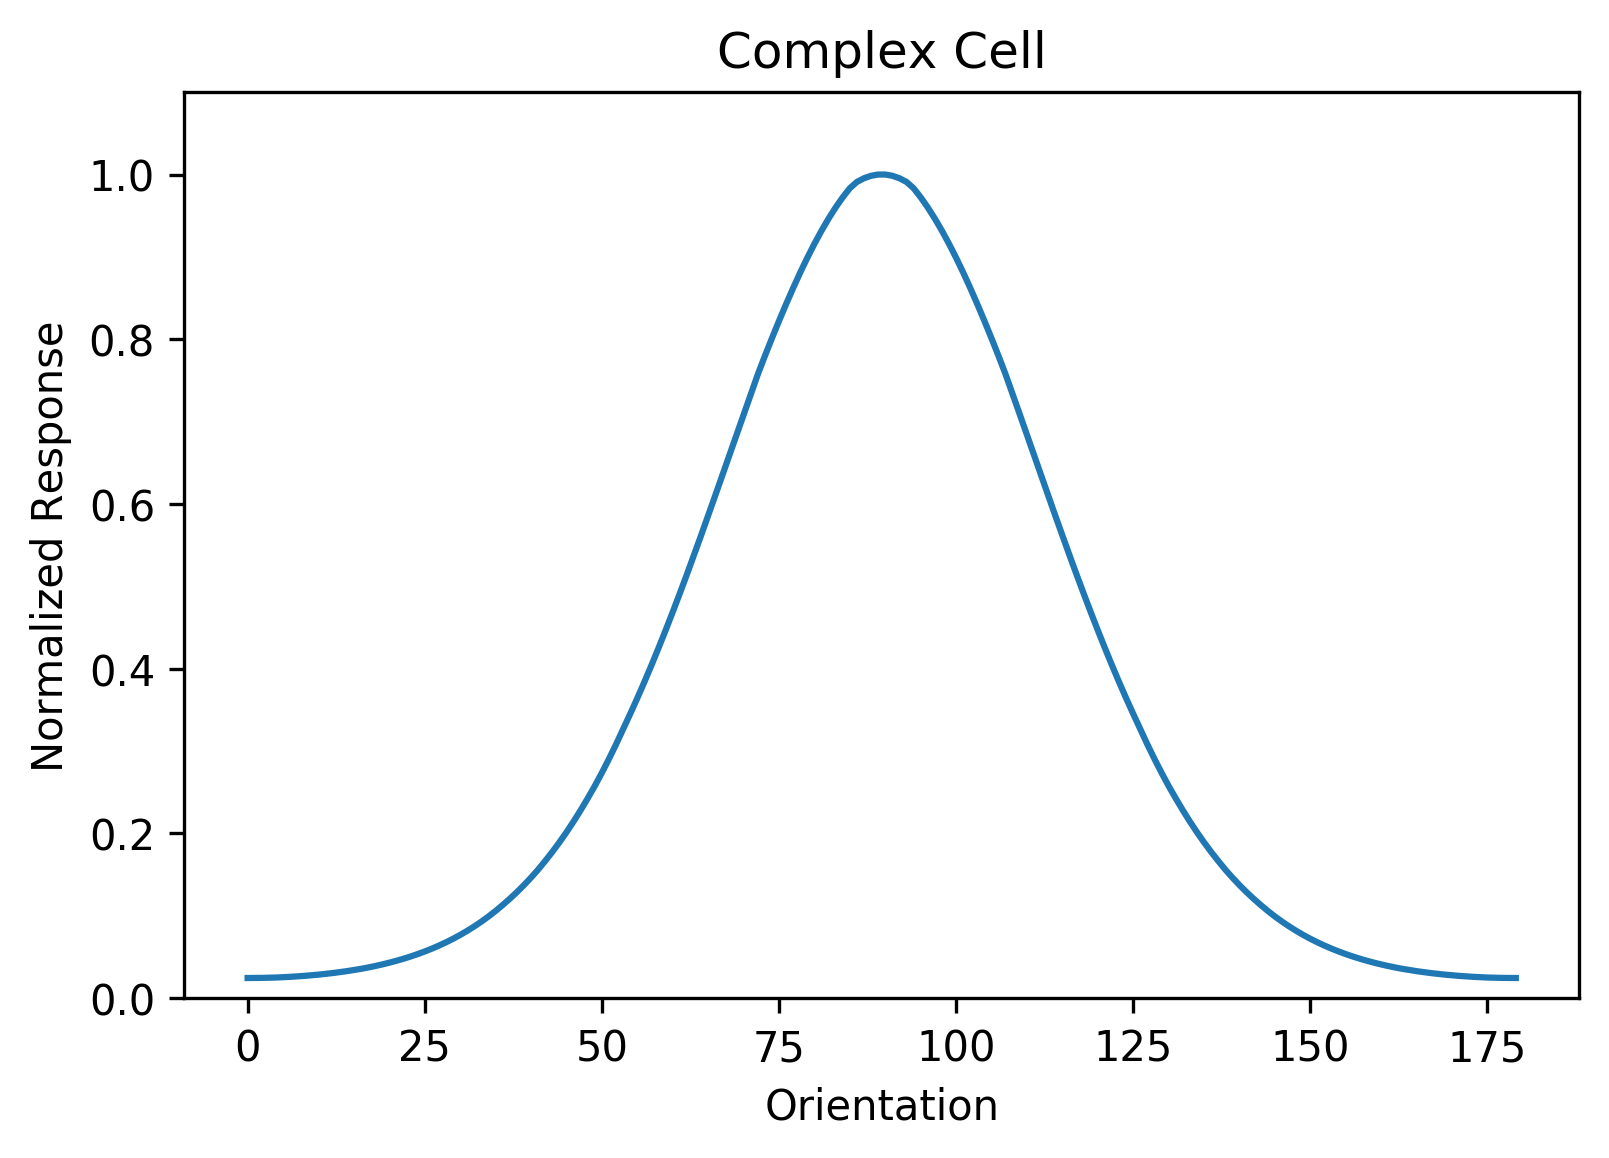

In [47]:
plt.figure(dpi=300)
responses_rotation_norm = responses_rotation/scale
responses_phase_norm = responses_phase/scale
plt.plot(responses_rotation_norm)

plt.ylim(0,1.1)
plt.title('Complex Cell')
plt.ylabel('Normalized Response')
plt.xlabel('Orientation')

Text(0.5, 0, 'Phase')

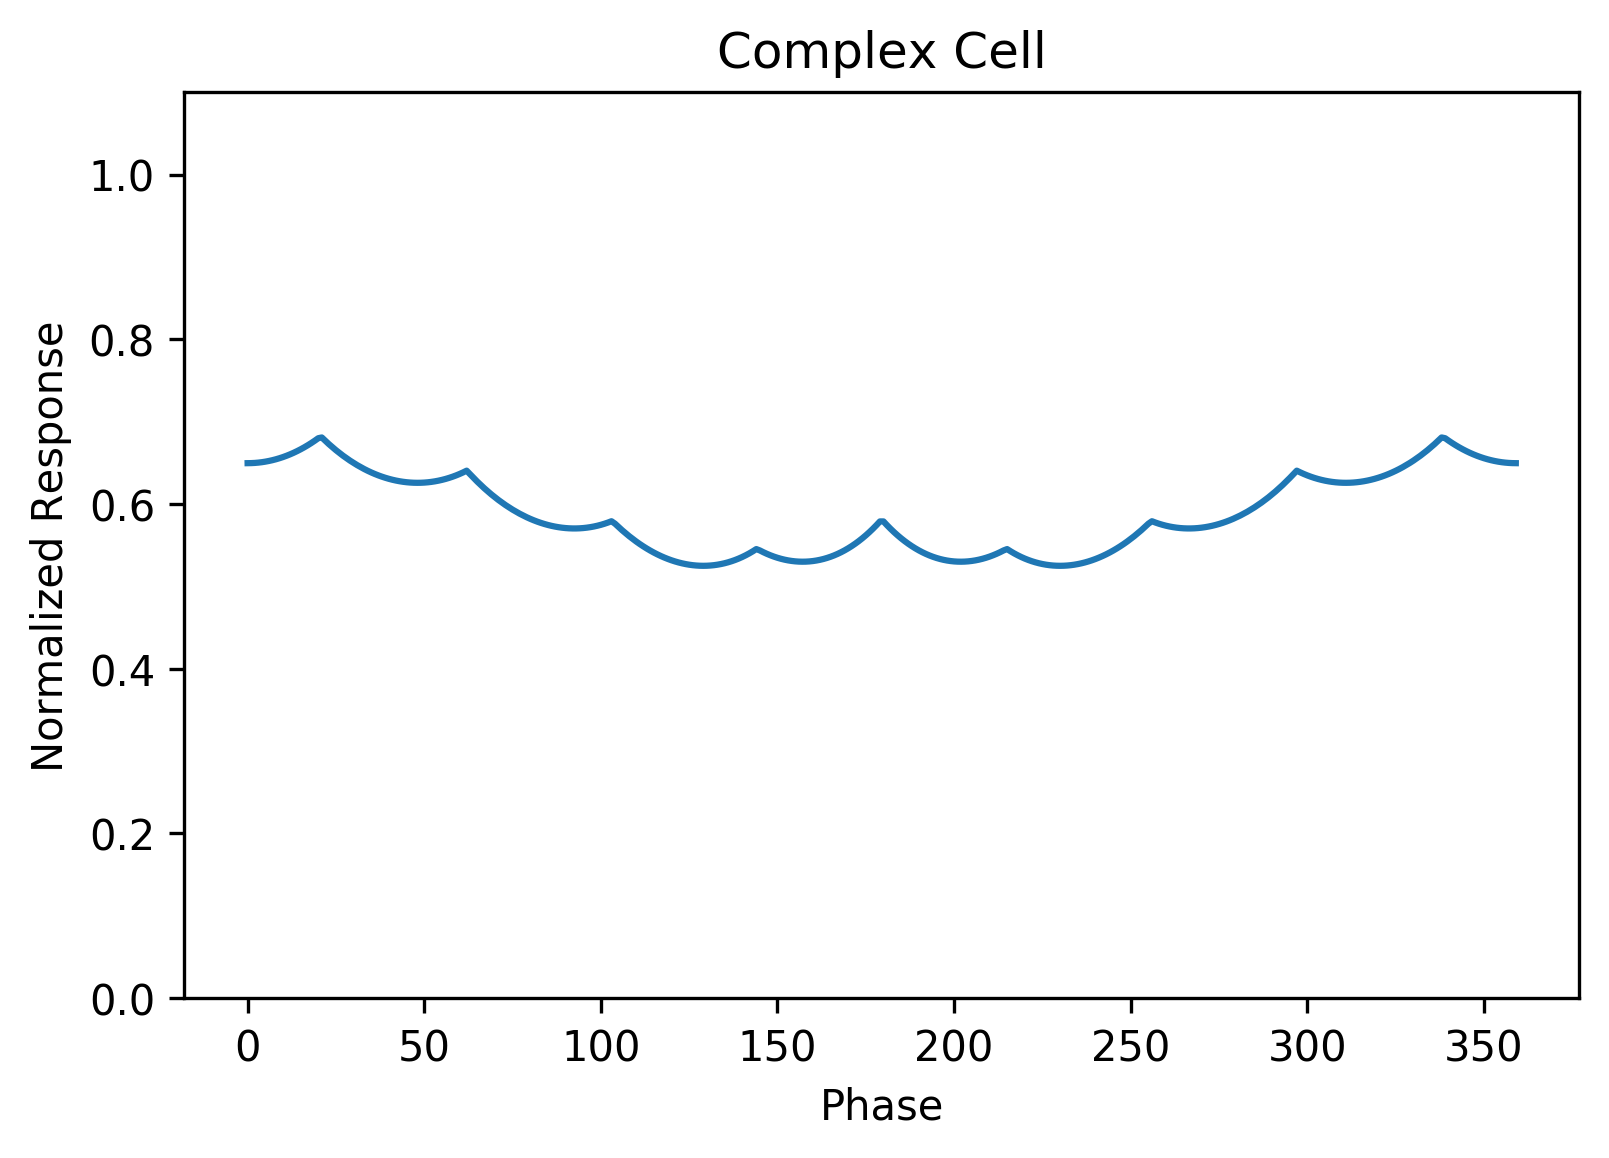

In [48]:
plt.figure(dpi=300)
plt.plot(responses_phase_norm, label='phase')
plt.ylim(0,1.1)
plt.title('Complex Cell')
plt.ylabel('Normalized Response')
plt.xlabel('Phase')

In [49]:
# gabor_data = np.load('data/gaborfig.npy')

In [50]:
net = np.load('results/net.npy', allow_pickle=True).item()

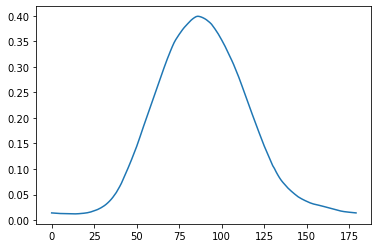

In [51]:
responses_rotation_CNN = []

for i in test_rotation:
    response = net(torch.tensor(i,dtype=torch.float,device='cuda')[None,None,:,:]).cpu().detach().numpy().squeeze()
    responses_rotation_CNN.append(response)

plt.plot(responses_rotation_CNN)

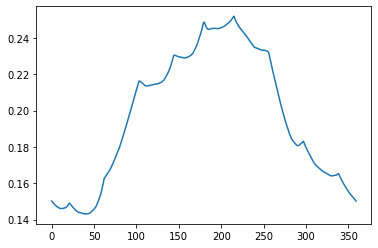

In [52]:
responses_phase_CNN = []

for i in test_phase:
    response = net(torch.tensor(i,dtype=torch.float,device='cuda')[None,None,:,:]).cpu().detach().numpy().squeeze()
    responses_phase_CNN.append(response)

plt.plot(responses_phase_CNN)

In [53]:
scale = max(responses_rotation_CNN)
responses_rotation_norm_CNN = responses_rotation_CNN/scale
responses_phase_norm_CNN = responses_phase_CNN/scale

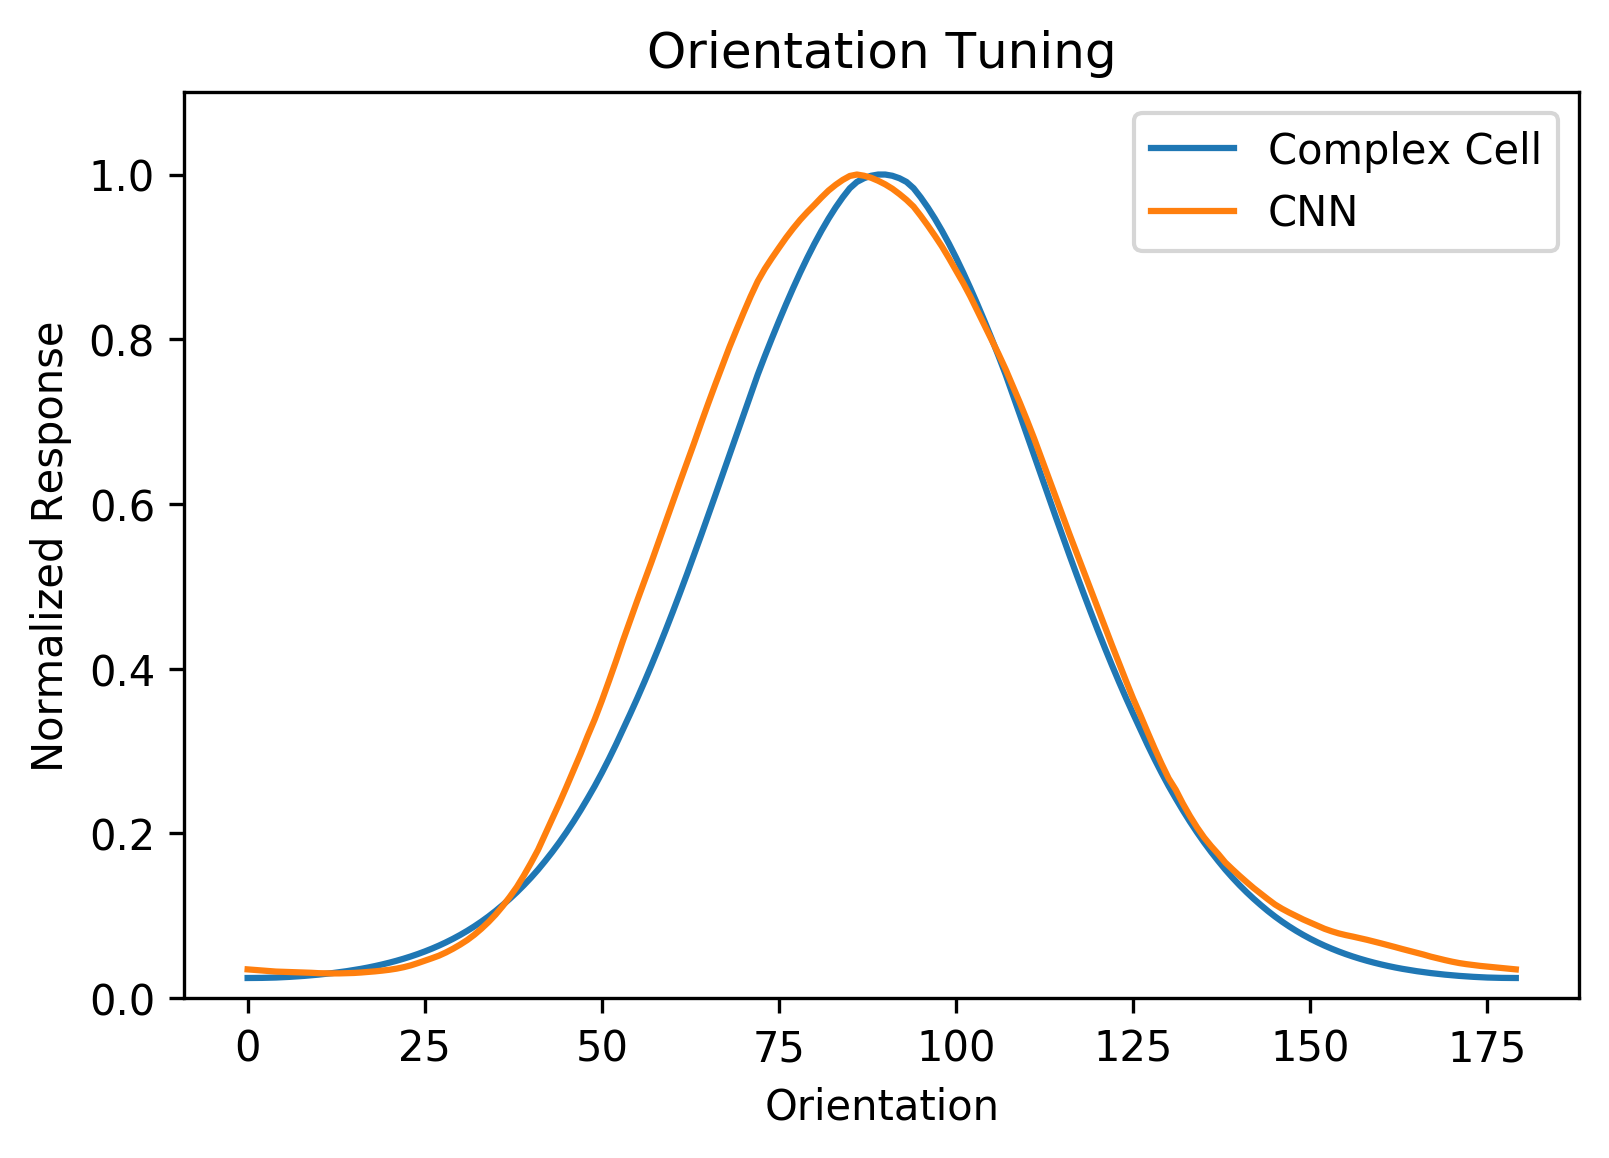

In [54]:
plt.figure(dpi=300)
plt.plot(responses_rotation_norm, label='Complex Cell')
plt.plot(responses_rotation_norm_CNN, label='CNN')
plt.ylim(0,1.1)
plt.title('Orientation Tuning')
plt.ylabel('Normalized Response')
plt.xlabel('Orientation')
plt.legend()

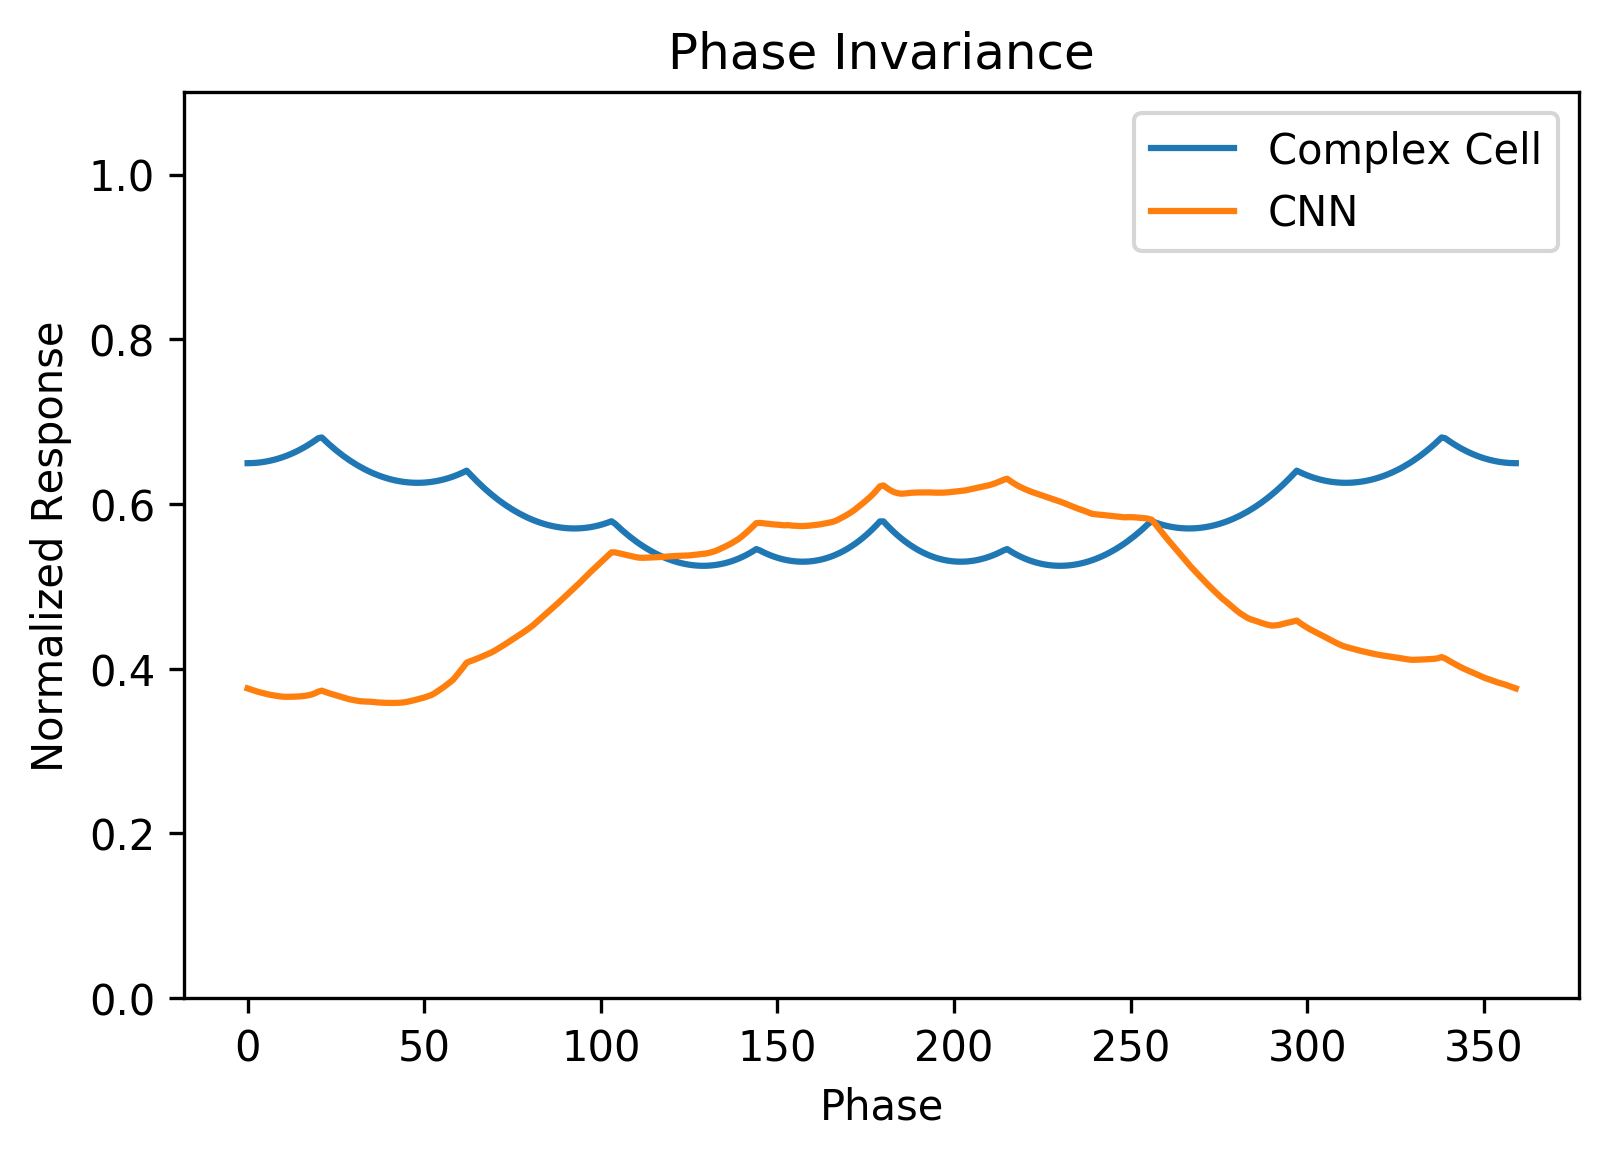

In [55]:
plt.figure(dpi=300)
plt.plot(responses_phase_norm, label='Complex Cell')
plt.plot(responses_phase_norm_CNN, label='CNN')
plt.ylim(0,1.1)
plt.title('Phase Invariance')
plt.ylabel('Normalized Response')
plt.xlabel('Phase')
plt.legend()

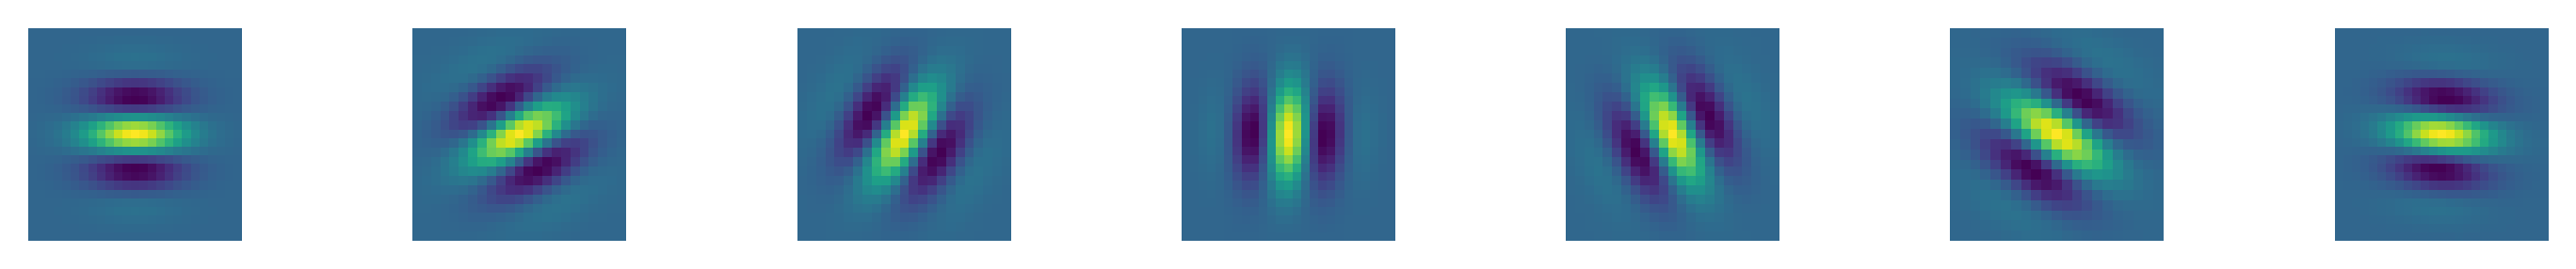

In [437]:
fig, axes = plt.subplots(1,7,figsize=(12,1),dpi=300)
for ax, im in zip(axes, gabor_rotation[::29]):
    ax.imshow(im)
    ax.axis('off')

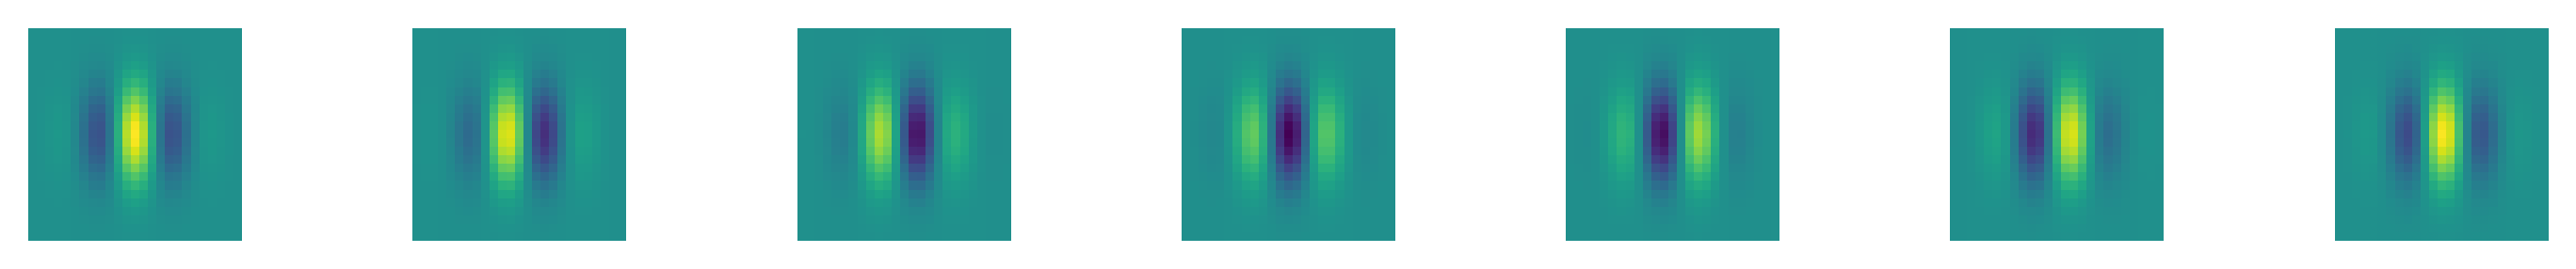

In [438]:
fig, axes = plt.subplots(1,7,figsize=(12,1),dpi=300)
for ax, im in zip(axes, gabor_phase[::29]):
    ax.imshow(im, vmin=0, vmax=1)
    ax.axis('off')